In [71]:
import pandas as pd
import numpy as np
import os.path
from os import path
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_rows', 500)

In [72]:
contributions = pd.read_csv("github-contribution.csv.gz")
contributions.date = pd.to_datetime(contributions.date * 1000000, utc = True)

In [73]:
github_apache_membership = pd.read_csv("asf-github-membership.csv.gz")


Latest record from the dataset:

In [74]:
contributions.sort_values("date", ascending=False).head(1)
# contributions = contributions[contributions.date > '2020-06-01']

,org,repo,type,identifier,subidentifier,date,author,owner
7843,apache,ozone,PR_COMMENTED,1766,NaN,2021-02-11 04:27:15+00:00,bharatviswa504,bharatviswa504


# Github Contributions per user


In [75]:
c = contributions[["identifier","author","type","owner"]].groupby(["author","type","owner"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[c.author != c.owner][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


,contributions
author,
bharatviswa504,1179
adoroszlai,1149
xiaoyuyao,1079
elek,932
bshashikant,354
avijayanhwx,337
dineshchitlangia,330
arp7,273
anuengineer,257


## Contributors per participations in PRs which are not created by self (helping PRs)

In [76]:
c = contributions[contributions.author != contributions.owner][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
adoroszlai,509
elek,413
bharatviswa504,295
xiaoyuyao,292
dineshchitlangia,146
avijayanhwx,143
bshashikant,140
arp7,126
anuengineer,121


## Contributors per participations in any PRs

In [77]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

,identifier
author,
adoroszlai,782
elek,596
bharatviswa504,427
xiaoyuyao,329
avijayanhwx,220
bshashikant,190
dineshchitlangia,164
vivekratnavel,154
mukul1987,139


# Bus factor (number of contributors responsible for the 50% of the prs) from last half year

## Contributors until the half of the all contributions

In [93]:
prcreated = contributions[contributions.type == "PR_CREATED"]
prcreated = prcreated[prcreated.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

,author,identifier,cs,ratio
0,adoroszlai,71,71,12.095400
1,elek,49,120,8.347530
2,GlenGeng,42,162,7.155026
3,amaliujia,33,195,5.621806
4,rakeshadr,25,220,4.258944
5,lamber-ken,22,242,3.747871
6,bharatviswa504,22,264,3.747871
7,captainzmc,21,285,3.577513


## Pony number (bus factor)

In [94]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

9

## Dev power (All the contributions in the ration of the top contributor)

In [80]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

8.26760563380282

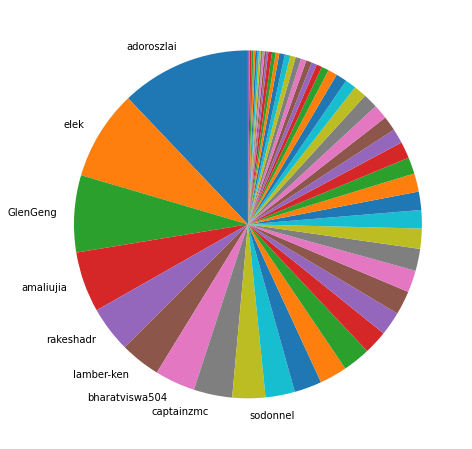

In [81]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created PRs > reviewed/commented PRS

In [82]:
created = contributions[contributions.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[contributions.author != contributions.owner][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

merged.index = merged.index.rename("githubname")
merged = merged.join(github_apache_membership.set_index("githubname")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})


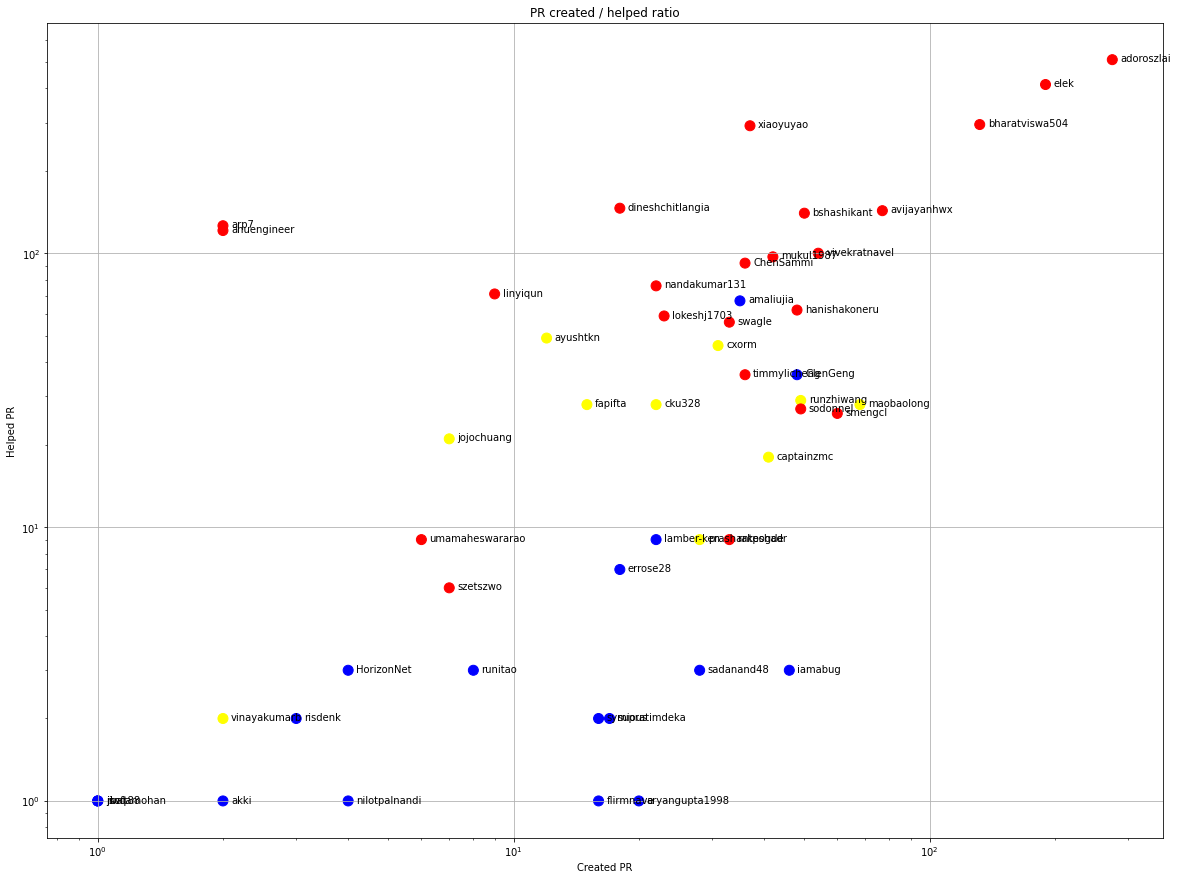

In [83]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["githubname"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

## Same graph with focusing to the last 6 month

Only contributors with both created pr and helped pr visible

In [84]:
import datetime

filtered = contributions[contributions.date > (datetime.datetime.now() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')]
created = filtered[filtered.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = filtered[filtered.author != filtered.owner][["identifier"]].groupby([filtered.author,filtered.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created,left_index=True, right_index=True)

merged.index = merged.index.rename("githubname")
merged = merged.join(github_apache_membership.set_index("githubname")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})
merged = merged.fillna(0)

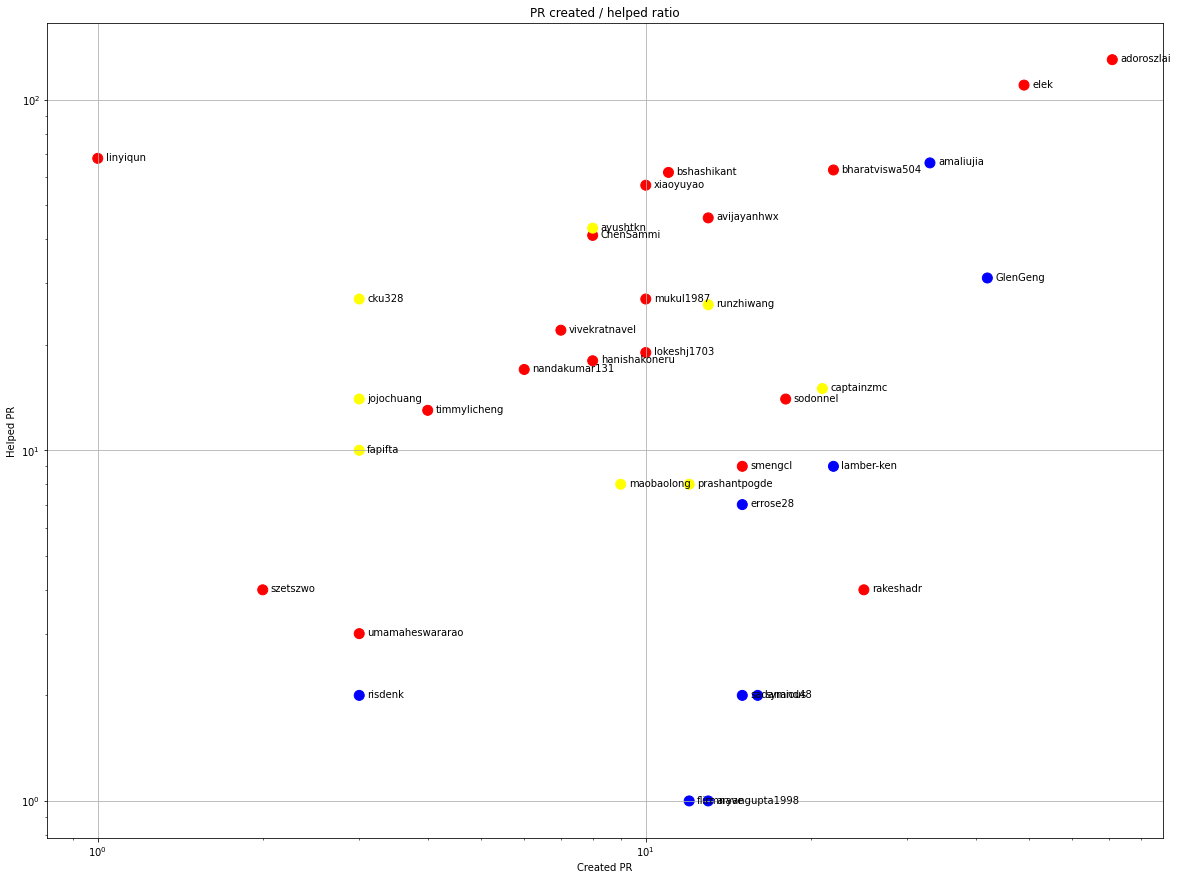

In [85]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
    plt.annotate(row["githubname"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
        
plt.semilogx()
plt.semilogy()
plt.show()


# Number of individual contributors per month

Number of different Github users who either created PR, commented PR, added review to a PR

Note: only events from apache/hadoop-ozone repository are included. Earlier PRs/comments are not here.

In [90]:


m = contributions[["identifier"]].groupby([contributions.date.dt.strftime('%Y').rename("year"),contributions.date.dt.strftime('%m').rename("month"),contributions.author]).count() \
  .reset_index()
m

result = m[["author"]].groupby([m.year,m.month]).count().sort_values(["year","month"]).reset_index()
result = result.pivot(index="year",columns="month",values="author").fillna(0)


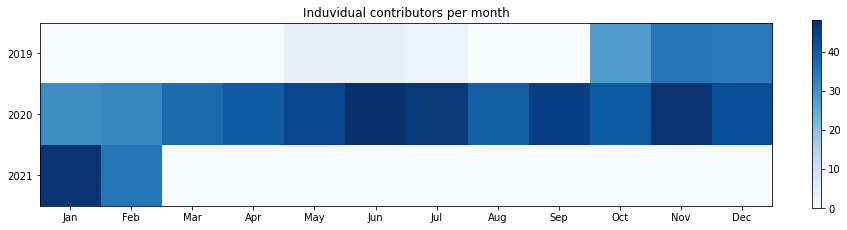

In [87]:
plt.figure(figsize=(14,11))
im = plt.imshow(result, cmap="Blues")
plt.yticks(range(len(result)),result.index.values)
plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.title("Induvidual contributors per month")
plt.colorbar(im, fraction=0.012)
plt.show()


# Number of PRs closed/created per month

In [34]:
a = contributions[contributions.type.isin(["PR_CREATED","PR_MERGED"])]
a = a[["identifier"]].groupby([a.date.dt.to_period("M"),a.type]).count().reset_index()
a = a.pivot(index="date",columns="type",values="identifier")
a.sort_values("date",ascending=False).head(10)
a.columns = ["created","merged"]
a = a.reset_index()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


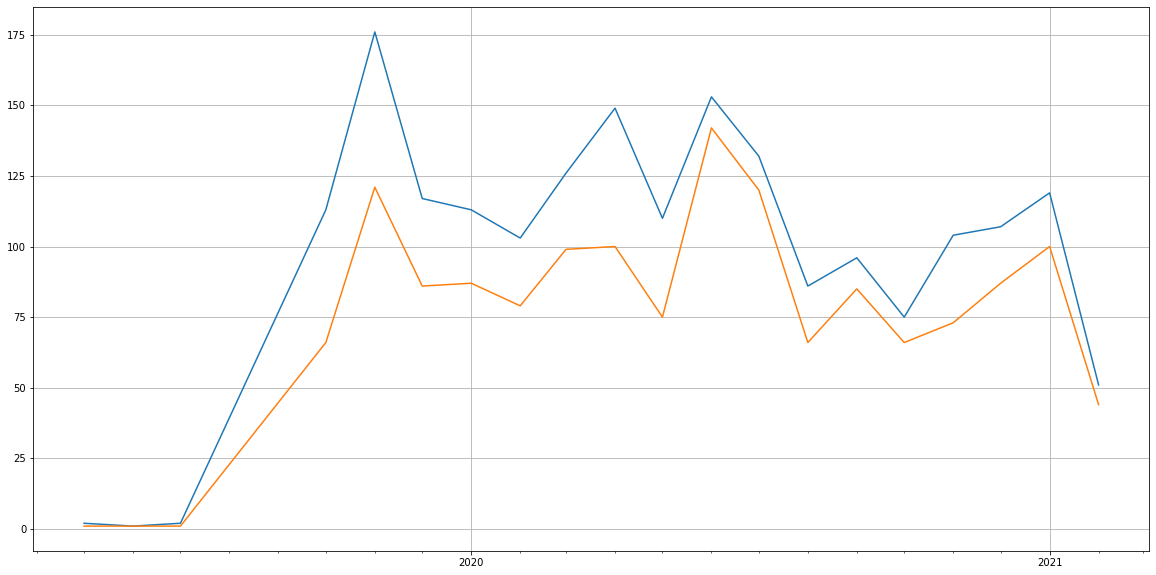

In [35]:
a['d'] = a['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'created', data=a)
ax.plot('d', 'merged', data=a)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

# PR activity heatmap

In [91]:
days = contributions.date.dt.strftime('%A')
hours = contributions.date.dt.strftime('%H')

a = contributions[["date"]].groupby([days,hours]).count()
a.columns = ["count"]
a.index.names = ["day","hour"]
a = a.reset_index()
a = a.pivot(index="day",columns="hour",values="count")
a = a.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])


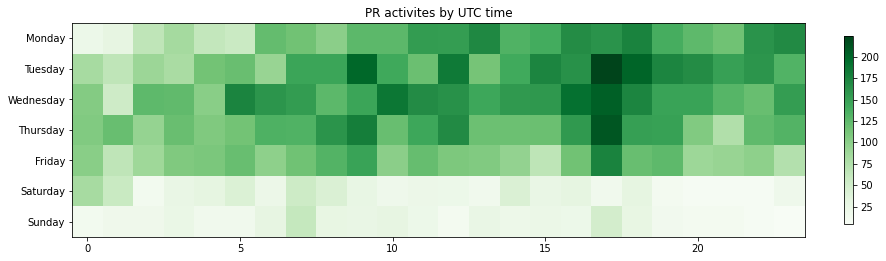

In [92]:
plt.figure(figsize=(14,11))
im = plt.imshow(a, cmap="Greens")
plt.yticks(range(len(a)),a.index.values)
plt.title("PR activites by UTC time")
plt.colorbar(im, fraction=0.012)
plt.show()
